In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
def process_file(file_name):
    folder = os.getcwd()
    pip_decimal_places = {'EURUSD':4, 'USDJPY':2, 'NZDUSD':4, 'USDCAD':4, 'AUDUSD':4}
    raw = pd.read_csv(f"{folder}/{file_name}")
    raw[['Open','High','Low','Close']] = raw[['Open','High','Low','Close']] * 10**pip_decimal_places[file_name[:6]]
    time_col = list(raw.columns)[0]
    raw.rename(columns={time_col:'Gmt time'}, inplace=True)
    return raw

# file = 'EURUSD_1h_2003-2010.csv'
# data = process_file(file)
# data

In [3]:
def get_data(files, plot=False):
    folder = os.getcwd()
    all_data = []
    for file in files:
        print(file)
        raw = process_file(file)
        time_col = list(raw.columns)[0]
        raw['time'] = pd.to_datetime(raw[time_col].str[:16], dayfirst=True)
        raw.drop(time_col,inplace=True, axis=1)
        raw['time'] = raw['time'].astype(np.int64) // 10 ** 9
        raw.drop('Volume', axis=1, inplace=True)
        raw['instrument'] = file[:6]
        if plot == True:
            raw['close'].plot()
        raw = raw[['time','instrument','Open','High','Low','Close']]
        data = raw.to_numpy()
        all_data.append(data)
    return all_data

# files = ['EURUSD_1h_2003-2010.csv']#, 'EURUSD_1h_2010-2020.csv']
# data = get_data(files)
# data

In [4]:
def fit_data_for_knn(all_data, window=20, n_candles=[1]):
    final_knn_data = []
    for data in all_data:
        knn_data = []
        for idx in range(len(data) - window - max(n_candles)):
            time_col = data[idx, 0]
            inst_col = data[idx, 1]
            row = data[idx:idx + window, 2:]
            # Normalise candles to 100 start (easy to calculate percentages later) (need to do more research)
            row = (row / row[0,0]) * 100
            ####
            next_candle = data[idx + window + 1, 2:]
            for c in n_candles:
                next_n_candle = data[idx + window + c, 2:]
                open_close_dist = ((next_n_candle[3] / next_candle[0]) - 1) * 100
                open_close_dist = open_close_dist / c**0.5
                row = np.append(row, open_close_dist)
            row = np.append(inst_col, row)
            row = np.append(time_col, row)
            knn_data.append(row.flatten())
        knn_data = pd.DataFrame(knn_data)
        target_cols = list(knn_data.columns)[-len(n_candles):]
        target_names = [f"target_bars_{c}" for c in n_candles]
        target_dict = dict(zip(target_cols, target_names))
        knn_data.rename(target_dict, axis='columns',inplace=True)
        final_knn_data.append(knn_data)
    final_knn = pd.concat(final_knn_data, axis=0)
    final_knn.sort_values(0, inplace=True)
    final_knn.reset_index(inplace=True, drop=True)
    final_knn.drop(0, axis=1, inplace=True)
    final_knn.drop(1, axis=1, inplace=True)
    print('fitted knn data')
    return final_knn

files = ['EURUSD_1h_2003-2010.csv']#, 'EURUSD_1h_2010-2020.csv']
data = get_data(files)
knn_data = fit_data_for_knn(data, window=10, n_candles=[1,2,3,4,5,6,7,8,9])
knn_data.head()

EURUSD_1h_2003-2010.csv
fitted knn data


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,target_bars_1,target_bars_2,target_bars_3,target_bars_4,target_bars_5,target_bars_6,target_bars_7,target_bars_8,target_bars_9
0,100.0,100.048092,99.962595,100.018703,99.991094,100.016031,99.948345,99.961704,99.956361,99.956361,99.889566,99.897581,99.890456,100.026718,99.884222,99.976844,99.953689,99.980407,99.835239,99.871754,99.872644,99.934986,99.822771,99.882441,99.856614,99.906487,99.790709,99.891347,99.834349,99.903815,99.817427,99.855723,99.861957,99.944783,99.828114,99.874426,99.861067,99.961704,99.805849,99.825443,-0.032106,-0.006937,0.043251,0.049942,0.009971,0.056434,0.098090,0.200222,0.169150
1,100.0,100.024939,99.957247,99.970608,99.965264,99.965264,99.898463,99.906479,99.899353,100.035627,99.893119,99.985749,99.962592,99.989312,99.844131,99.880649,99.881540,99.943887,99.831662,99.891337,99.865508,99.915386,99.799597,99.900244,99.843241,99.912714,99.826318,99.864617,99.870852,99.953685,99.837006,99.883321,99.869961,99.970608,99.814739,99.834334,99.847694,99.936762,99.768424,99.883321,0.032119,0.082646,0.081903,0.032119,0.080599,0.123113,0.229985,0.194312,0.240895
2,100.0,100.000000,99.933176,99.941195,99.934067,100.070388,99.927830,100.020493,99.997327,100.024057,99.878826,99.915356,99.916247,99.978616,99.866352,99.926048,99.900209,99.950105,99.834276,99.934958,99.877935,99.947432,99.861006,99.899318,99.905555,99.988417,99.871698,99.918029,99.904664,100.005346,99.849423,99.869025,99.882390,99.971488,99.803092,99.918029,99.905555,99.973270,99.838731,99.873480,0.109733,0.095257,0.032965,0.086538,0.131662,0.245481,0.205016,0.252966,0.216790
3,100.0,100.136411,99.993759,100.086483,100.063302,100.090049,99.944722,99.981277,99.982168,100.044579,99.932240,99.991976,99.966120,100.016048,99.900144,100.000892,99.943831,100.013374,99.926891,99.965229,99.971470,100.054386,99.937590,99.983952,99.970578,100.071326,99.915300,99.934915,99.948289,100.037446,99.868938,99.983952,99.971470,100.039229,99.904601,99.939373,99.929566,100.000000,99.893903,99.961662,-0.009799,-0.061733,0.016459,0.074832,0.203982,0.162205,0.215495,0.178585,0.152039
4,100.0,100.026730,99.881495,99.918027,99.918918,99.981289,99.869021,99.928719,99.902880,99.952776,99.836945,99.937629,99.880604,99.950103,99.863675,99.901989,99.908226,99.991090,99.874367,99.920700,99.907335,100.008019,99.852092,99.871694,99.885060,99.974161,99.805759,99.920700,99.908226,99.975943,99.841400,99.876149,99.866348,99.936738,99.830708,99.898425,99.873476,100.050788,99.856547,99.983071,-0.083743,0.022678,0.088469,0.229848,0.179287,0.234224,0.192269,0.162527,0.156202


In [5]:
target = [f'target_bars_{b}' for b in range(1,10)]
features = [c for c in list(knn_data.columns) if c not in target]
x_train = knn_data[features]
pca = PCA(n_components=5)
pca_data = pca.fit_transform(x_train)
print(sum(pca.explained_variance_ratio_))
pca_data

0.9536510687765953


array([[-0.67235179, -0.00578789, -0.0494638 ,  0.0220949 , -0.17158764],
       [-0.68490756, -0.06215385, -0.01281422, -0.0034494 , -0.15207829],
       [-0.52956299, -0.05575355, -0.00589714, -0.04972822, -0.13813067],
       ...,
       [-0.04255723, -0.09440969,  0.00691704, -0.04331752, -0.25322445],
       [-0.02877458, -0.10303572,  0.04714336, -0.00684381, -0.25298662],
       [ 0.02909325, -0.07558479,  0.0610451 ,  0.03753932, -0.25562369]])

In [6]:
len(pca_data)

41727

In [26]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 41727 samples in 0.019s...
[t-SNE] Computed neighbors for 41727 samples in 2.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41727
[t-SNE] Computed conditional probabilities for sample 2000 / 41727
[t-SNE] Computed conditional probabilities for sample 3000 / 41727
[t-SNE] Computed conditional probabilities for sample 4000 / 41727
[t-SNE] Computed conditional probabilities for sample 5000 / 41727
[t-SNE] Computed conditional probabilities for sample 6000 / 41727
[t-SNE] Computed conditional probabilities for sample 7000 / 41727
[t-SNE] Computed conditional probabilities for sample 8000 / 41727
[t-SNE] Computed conditional probabilities for sample 9000 / 41727
[t-SNE] Computed conditional probabilities for sample 10000 / 41727
[t-SNE] Computed conditional probabilities for sample 11000 / 41727
[t-SNE] Computed conditional probabilities for sample 12000 / 41727
[t-SNE] Computed conditional probabilities for sa

In [30]:
tsne_results.shape

(41727, 2)

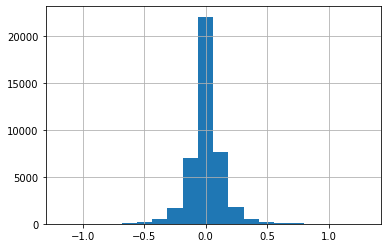

In [57]:
target = 'target_bars_5'
all_results = pd.DataFrame(tsne_results)
all_results['target'] = knn_data[target]
all_results['target'].hist(bins=20)

In [129]:
all_results = all_results[(all_results['target'] < -0.2) | (all_results['target'] > 0.2)]
all_results['categories'] = pd.cut(all_results['target'],bins=5)
categories = all_results['categories'].unique()
print(categories)
all_results['categories'].value_counts()

[(-0.187, 0.308], (0.308, 0.803], (-0.682, -0.187], (-1.179, -0.682], (0.803, 1.298]]
Categories (5, interval[float64]): [(-1.179, -0.682] < (-0.682, -0.187] < (-0.187, 0.308] < (0.308, 0.803] < (0.803, 1.298]]


(-0.682, -0.187]    2134
(-0.187, 0.308]     1411
(0.308, 0.803]       765
(-1.179, -0.682]      40
(0.803, 1.298]        25
Name: categories, dtype: int64

In [130]:
# filter_results = all_results[all_results['categories'] == categories[7]]
# filter_results['categories'].unique()
filter_results = all_results.copy()

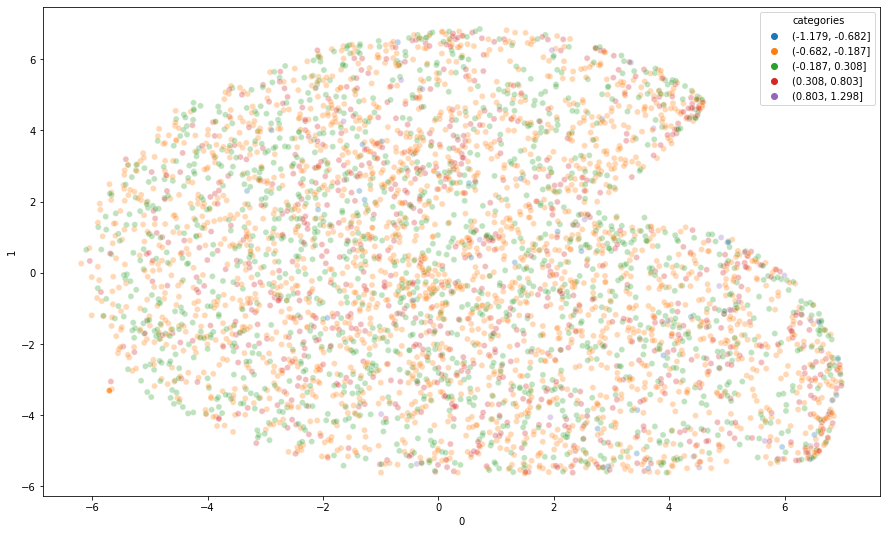

In [131]:
import seaborn as sns

plt.figure(figsize=(15,9))
sns.scatterplot(
    x=filter_results[0], y=filter_results[1],
    hue=filter_results['categories'],
    #palette=sns.color_palette("hls", 10),
    #legend="full",
    alpha=0.3
)